In [4]:
!pip install pmdarima
!pip install finance-datareader
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

     |████████████████████████████████| 1.4 MB 12.5 MB/s 
     |████████████████████████████████| 9.8 MB 57.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
df_krx = fdr.StockListing('KRX')
symbol = df_krx[df_krx['Name']=='삼성전자']['Symbol']

In [6]:
a= fdr.DataReader('005930'.join(symbol.values),'2019-12-31')

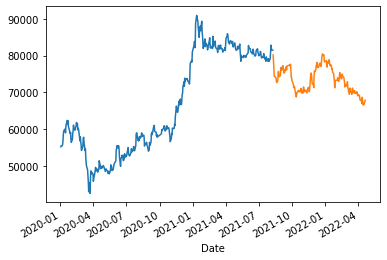

In [8]:
y_train=a['Close'][:int(0.7*len(a))]
y_test = a['Close'][int(0.7*len(a)):]
y_train.plot()
y_test.plot()

In [9]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [10]:
model = pm.auto_arima(y = y_train,
                      d=1,
                      start_p=0,
                      max_p=3,
                      start_q=0,
                      max_q=3,
                      m=1,
                      seasonal=False,
                      stepwise=True,
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6740.858, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6742.755, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6742.769, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6740.179, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6744.767, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.418 seconds


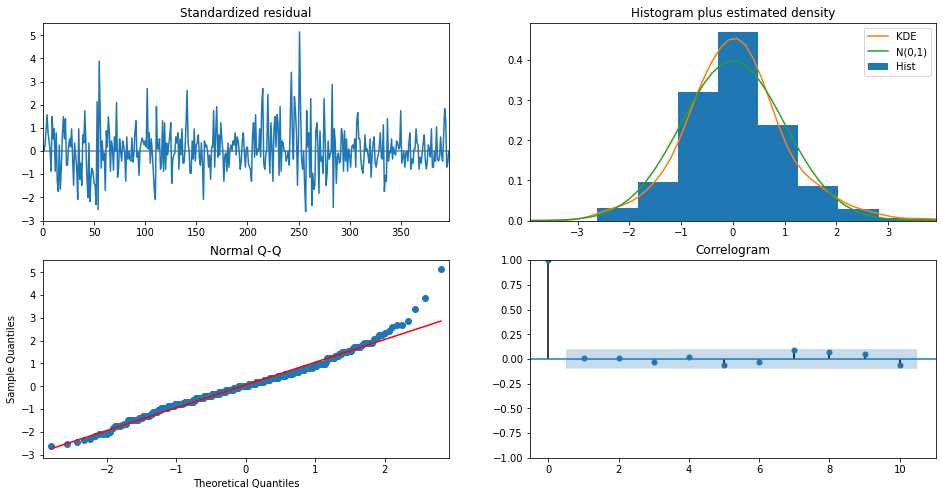

In [11]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [12]:
model.fit(y_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

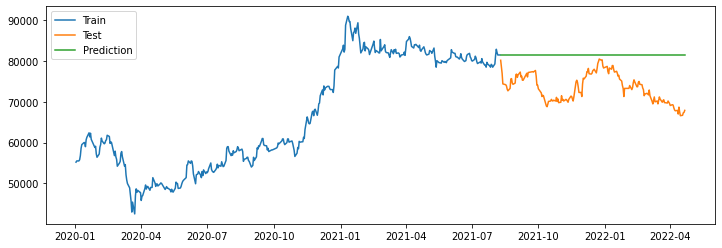

In [13]:
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [14]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [15]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower=[]

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    
    ## 모형 업데이트 !!
    model.update(new_ob)

In [16]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
Date,,
2021-08-10,80200,81500.0
2021-08-11,78500,80200.0
2021-08-12,77000,78500.0
2021-08-13,74400,77000.0
2021-08-17,74200,74400.0
...,...,...
2022-04-15,66600,67500.0
2022-04-18,66700,66600.0
2022-04-19,67300,66700.0


In [17]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터 -----------------------------------------------
go.Scatter(x= y_train.index, y= y_train, name ="train", mode="lines", line=dict(color='royalblue'))
, # 테스트 데이터 -----------------------------------------------
go.Scatter(x= y_test.index, y= y_test, name ="Test", mode="lines", line=dict(color='rgba(0,0,30,0.5)')),
 # 예측값 -----------------------------------------------
go.Scatter(x= y_test.index, y= y_pred, name ="Prediction", mode="lines", line=dict(color='red', dash='dot', width=3)),
 # 신뢰구간-----------------------------------------------
go.Scatter(x= y_test.index.tolist() + y_test.index[::-1].tolist(),
           y = pred_upper+pred_lower[::-1],
           fill='toself',
           fillcolor='rgba(0,0,30,0.1)',
           line=dict(color='rgba(0,0,0,0)'),
           hoverinfo="skip",
           showlegend=False)])
fig.update_layout(height=400, width=1000, title_text ="ARIMA(0,1,0)모형")
fig.show()